# Вводная часть

Оператор мобильной связи `«Мегалайн»` выяснил: многие клиенты пользуются архивными тарифами. Необходимо построить модель, способную проанализировать поведение клиентов и предложить пользователям новый тариф: `«Смарт»` или `«Ультра»`.

# Рекомендация тарифов

**Цель исследования** Нужно построить модель для задачи классификации, которая выберет подходящий тариф для клиента. В нашем распоряжении данные о поведении клиентов, которые уже перешли на данные тарифы.

**Основные задачи:**
- Построить модель с максимально большим значением *accuracy*, довести долю правильных ответов по крайней мере до 0.75. 
- Проверьте *accuracy* на тестовой выборке

# Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

# Этапы работы

1. [Открытие и изучение данных](#section1)
2. [Разбитие данных на выборки](#section2)
3. [Исследование моделей](#section3)
4. [Провека модели на тестовой выборке](#section4)
5. [Проверка модели на адекватность](#section5)
6. [Общий вывод](#section6)

<a id = 'section1'></a>
# Открытие и изучение данных

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.isna().mean()

calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

Отлично, пропущенных значенией нет

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Тип данных переменных определен корректно

In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Выбивающиеся переменные не обнаружены, отрицательные переменные отсутствуют, минимальное значение переменных везеде 0

In [8]:
df.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

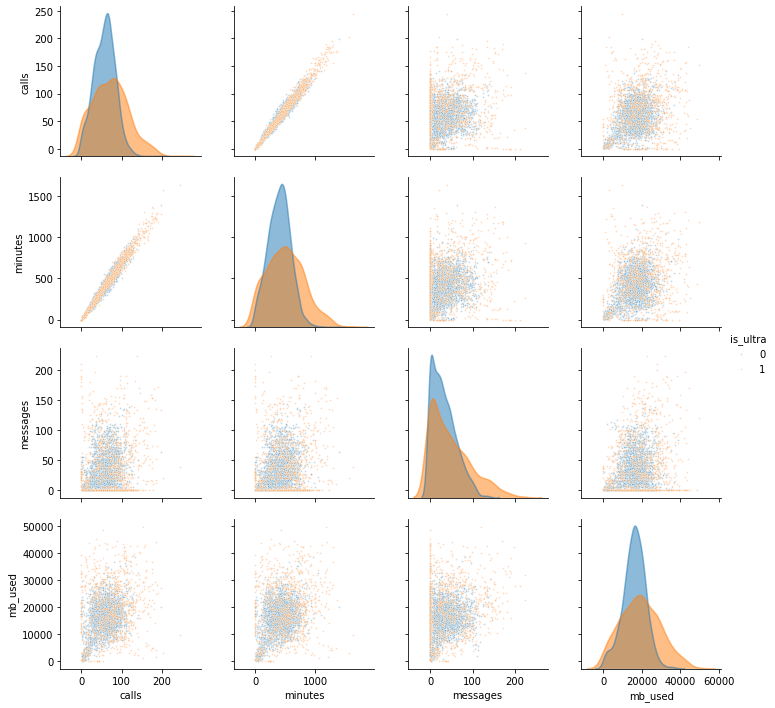

In [9]:
g = sns.pairplot(df, hue = 'is_ultra',
                x_vars=['calls', 'minutes', 'messages', 'mb_used'], 
                y_vars=['calls', 'minutes', 'messages', 'mb_used'],
                diag_kws = dict(alpha = 0.5), plot_kws = dict(alpha = 0.3, s = 3)
                )
g

Выявлены следующие закономерности:
- Явно кол-во звонков `calls` и длительность всех разговоров в минутах `minutes` коррелируют между собой
- Наблюдается дисбаланс классов для целевой переменной, доля клиентов с тарифом **ultra** всего 30,65 %. Следует обратить на это внимание при выделении выборок для ML.

## Вывод по шагу:

- Данные загружены
- Данные изучены: Пропущенные значения отсутсвуют, тип данных логичен и соответсвуют представленным переменным, явных артефактов не обнаружено в датафрейме.
- Следует обратить внимание на дисбаланс классов для целевой перменой `is_ultra`, что следует учесть при дроблении датафрейса на выборки

<a id = 'section2'></a>
# Разбитие данных на выборки

In [11]:
df_copy = df.copy()

Разделим датафрейм на признаки и целевой признак

In [12]:
def features(data, target_column):
    features_df = data.drop([target_column], axis = 1)
    target_df = data[target_column]
    return features_df, target_df

In [13]:
features_df, target_df = features(df_copy, 'is_ultra')

Разобьем данные на обучающую, валидационную и тестовую выборку

In [14]:
features_df_train, features_df_valid_test, target_df_train, target_df_valid_test = (
    train_test_split(features_df, target_df, test_size = 0.4, stratify =target_df, random_state=1)
)

In [15]:
features_df_valid, features_df_test, target_df_valid, target_df_test = (
    train_test_split(features_df_valid_test, target_df_valid_test, test_size = 0.5, stratify = target_df_valid_test, 
                     random_state=1))

В исходном датасете доля абонентов ультра составила 30,65%. Теперь проверим какое соотношение в разбитых выборках

In [16]:
def percentage_of_classes_check(data, name):
    print('Доля класса is_ultra в {} выборке : {:.2%}'.format(name, data.mean()))

In [17]:
percentage_of_classes_check(target_df, 'исходной')
percentage_of_classes_check(target_df_train, 'обучающей')
percentage_of_classes_check(target_df_valid, 'валидационной')
percentage_of_classes_check(target_df_test, 'тестовой')

Доля класса is_ultra в исходной выборке : 30.65%
Доля класса is_ultra в обучающей выборке : 30.65%
Доля класса is_ultra в валидационной выборке : 30.64%
Доля класса is_ultra в тестовой выборке : 30.64%


Сейчас выборки разбиты корректно, соотношения класса `is_ultra` одинаково, можно начать учить модели.

## Вывод по шагу:

Исходный датафрейм поделен на 3 выборки в соотношении 60% обучающая выборка, 20% валидационная выборка и 20% тестовая выборка. При делении учтен дисбаланс классов для целевой перменой `is_ultra`, доля класса во всех выборках и исходном датафрейме около 30,64%.

<a id = 'section3'></a>
# Исследование моделей

## Дерево решений

In [19]:
model = DecisionTreeClassifier(random_state=1)

Обучим модель на обучающей выборке

In [20]:
model.fit(features_df_train, target_df_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

Модель обучена, итак попробуем предсказать данные по данной обучающей выборке

In [21]:
train_predictions = model.predict(features_df_train)

Проверим долю правильны ответов `accuracy`. Модель предсказала все ответы верно. Но является ли модель реально рабочей или же она тупо запомнила ответы?

In [23]:
train_accuracy = accuracy_score(target_df_train, train_predictions)
train_accuracy

1.0

In [24]:
valid_predictions = model.predict(features_df_valid)

Предскажем данные валидационной выборки и проверим `accuracy` повторно

In [25]:
valid_accuracy = accuracy_score(target_df_valid, valid_predictions)
valid_accuracy

0.7013996889580093

Что в итоге? Доля правильны ответов на валидационной выборке лишь 70,13%. Может ли модель лучше? Посмотрим, что представляет собой дерево. 

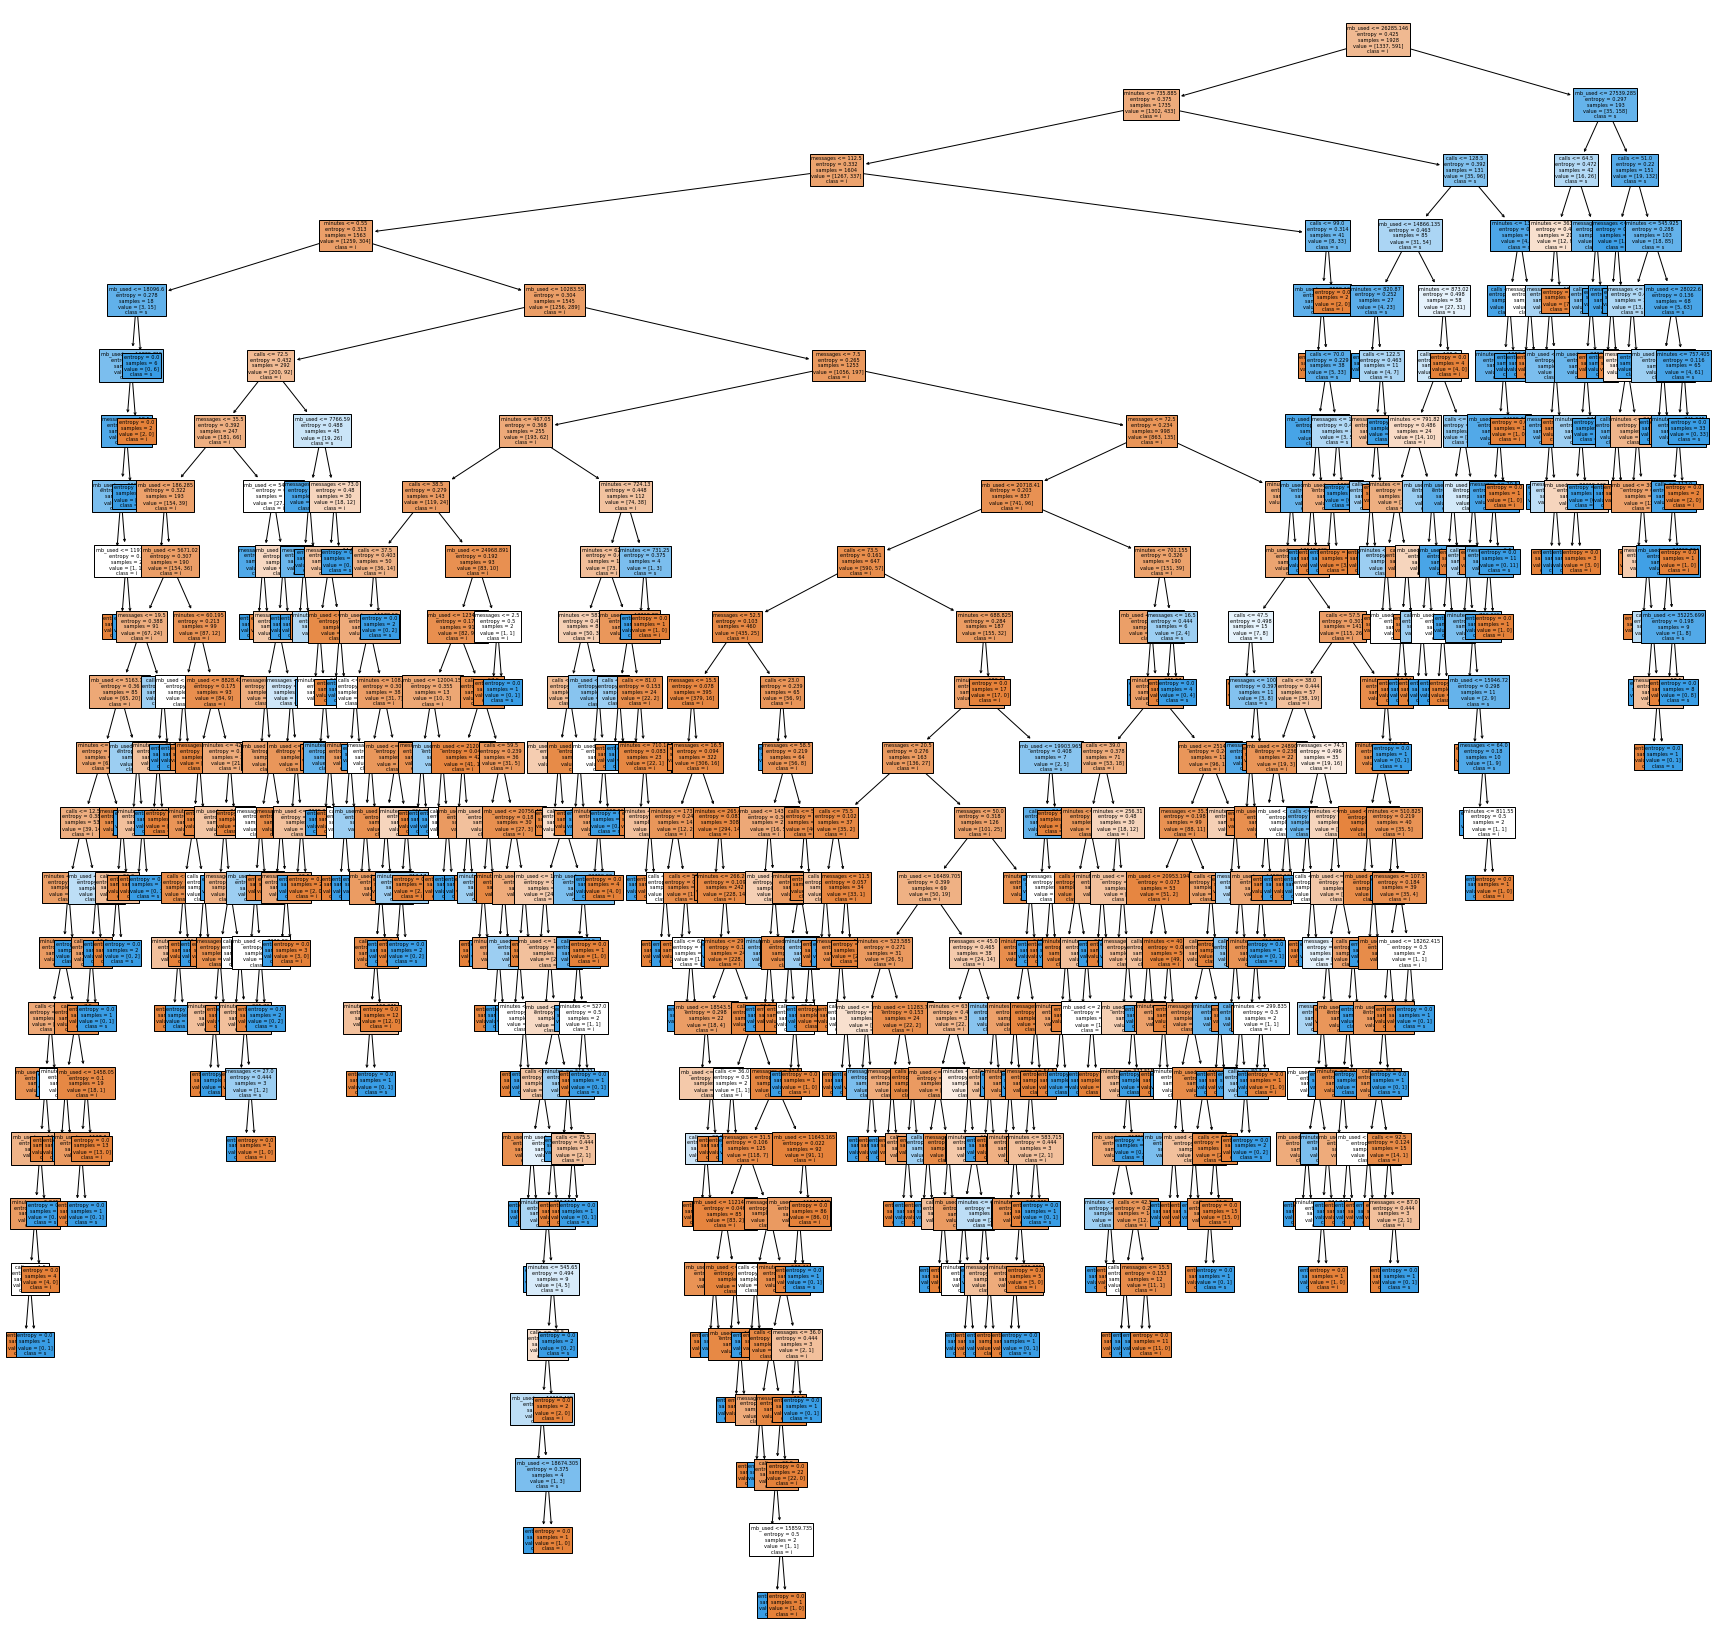

In [27]:
plt.figure(figsize=(30,30))
tree.plot_tree(model,feature_names=features_df_train.columns,
               class_names=target_df_train.name, filled=True, fontsize=5)
plt.show()

Модель явно переобучена. Попробуем настроить один из гиперпараметров - высоту дерева, чтобы увеличить долю правильных ответов.

In [28]:
best_max_depth = None
best_result = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_max_depth = depth
print('Наилучший Accuracy:', best_result, 'c глубиной дерева', best_max_depth)

Наилучший Accuracy: 0.7931570762052877 c глубиной дерева 9


In [29]:
best_max_depth = None
best_result = 0
for depth in range(1, 100):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_max_depth = depth
print('Наилучший Accuracy:', best_result, 'c глубиной дерева', best_max_depth)

Наилучший Accuracy: 0.7931570762052877 c глубиной дерева 9


In [30]:
best_max_depth = None
best_result = 0
for depth in range(1, 1000):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_max_depth = depth
print('Наилучший Accuracy:', best_result, 'c глубиной дерева', best_max_depth)

Наилучший Accuracy: 0.7931570762052877 c глубиной дерева 9


Итак как бы мы не увеличивали высоту дерева, наилучший результат 0,7931 приходится на высоту 9. Что ж рост параметра на 9% не так и плохо, но все равно не идеально, попробуем "поколдовать" с другими гипер параметрами 

Попробуем посмотреть как измениться `accuracy` для модели если покрутим максимальное число признаков, по которым ищется наилучшее разбиение  `max_features`

In [31]:
for features in range(1, 5):
    model = DecisionTreeClassifier(random_state=1, max_features=features)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    print('max_features =', features, ':', result)

max_features = 1 : 0.7107309486780715
max_features = 2 : 0.71850699844479
max_features = 3 : 0.7216174183514774
max_features = 4 : 0.7013996889580093


Так как у нас всего 4 признака в модели, то взят интервал от 1 до 4. Получилось, что модель, где классивикация оценивается лишь по 3 признакам, дает наилучший результат со значением 0,7216. С высотой дерева получилось лучше

Теперь попробуем изменить минимальное число объектов которое будет содержаться в листе дерева - параметр `min_samples_leaf`. 

In [32]:
best_min_samples_leaf = None
best_result = 0
for leaf in range(1, 10):
    model = DecisionTreeClassifier(random_state=1, min_samples_leaf=leaf)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_min_samples_leaf = leaf
print('Наилучший Accuracy:', best_result, 'с минимальным числом объектов в листе', best_min_samples_leaf)

Наилучший Accuracy: 0.7744945567651633 с минимальным числом объектов в листе 9


In [33]:
best_min_samples_leaf = None
best_result = 0
for leaf in range(1, 100):
    model = DecisionTreeClassifier(random_state=1, min_samples_leaf=leaf)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_min_samples_leaf = leaf
print('Наилучший Accuracy:', best_result, 'с минимальным числом объектов в листе', best_min_samples_leaf)

Наилучший Accuracy: 0.7993779160186625 с минимальным числом объектов в листе 26


In [34]:
best_min_samples_leaf = None
best_result = 0
for leaf in range(1, 1000):
    model = DecisionTreeClassifier(random_state=1, min_samples_leaf=leaf)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_min_samples_leaf = leaf
print('Наилучший Accuracy:', best_result, 'с минимальным числом объектов в листе', best_min_samples_leaf)

Наилучший Accuracy: 0.7993779160186625 с минимальным числом объектов в листе 26


В итоге если в листе дерева минимум 26 элементов, то модель предсказывает с точностью 0,7993 что немного лучше с максимальной высотой дерева в 9 элементов и точностью 0,7931

Попробуем теперь поиграться со всеми гиперпараметрами одновременно, подставим все оптимальные гиперпараметры подобранные ранее, кроме глубины дерева.

In [35]:
best_max_depth = None
best_result = 0
for depth in range(1, 100):
    dtc = DecisionTreeClassifier(random_state=1, min_samples_leaf =26, max_features = 3, max_depth=depth)
    dtc.fit(features_df_train, target_df_train)
    valid_predictions = dtc.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_max_depth = depth
print('Наилучший Accuracy:', best_result, 'c глубиной дерева', best_max_depth)

Наилучший Accuracy: 0.8009331259720062 c глубиной дерева 7


Так как по умолчанию использовался критерий разбиения Gini impurity теперь воспользуемся entropy.

In [36]:
best_max_depth = None
best_result = 0
for depth in range(1, 100):
    model = DecisionTreeClassifier(random_state=1, criterion = 'entropy',
                                   min_samples_leaf =26, max_features = 3, max_depth=depth)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_max_depth = depth
print('Наилучший Accuracy:', best_result, 'c глубиной дерева', best_max_depth)

Наилучший Accuracy: 0.7978227060653188 c глубиной дерева 5


Посмотрим как выглядит дерево после оптимизации

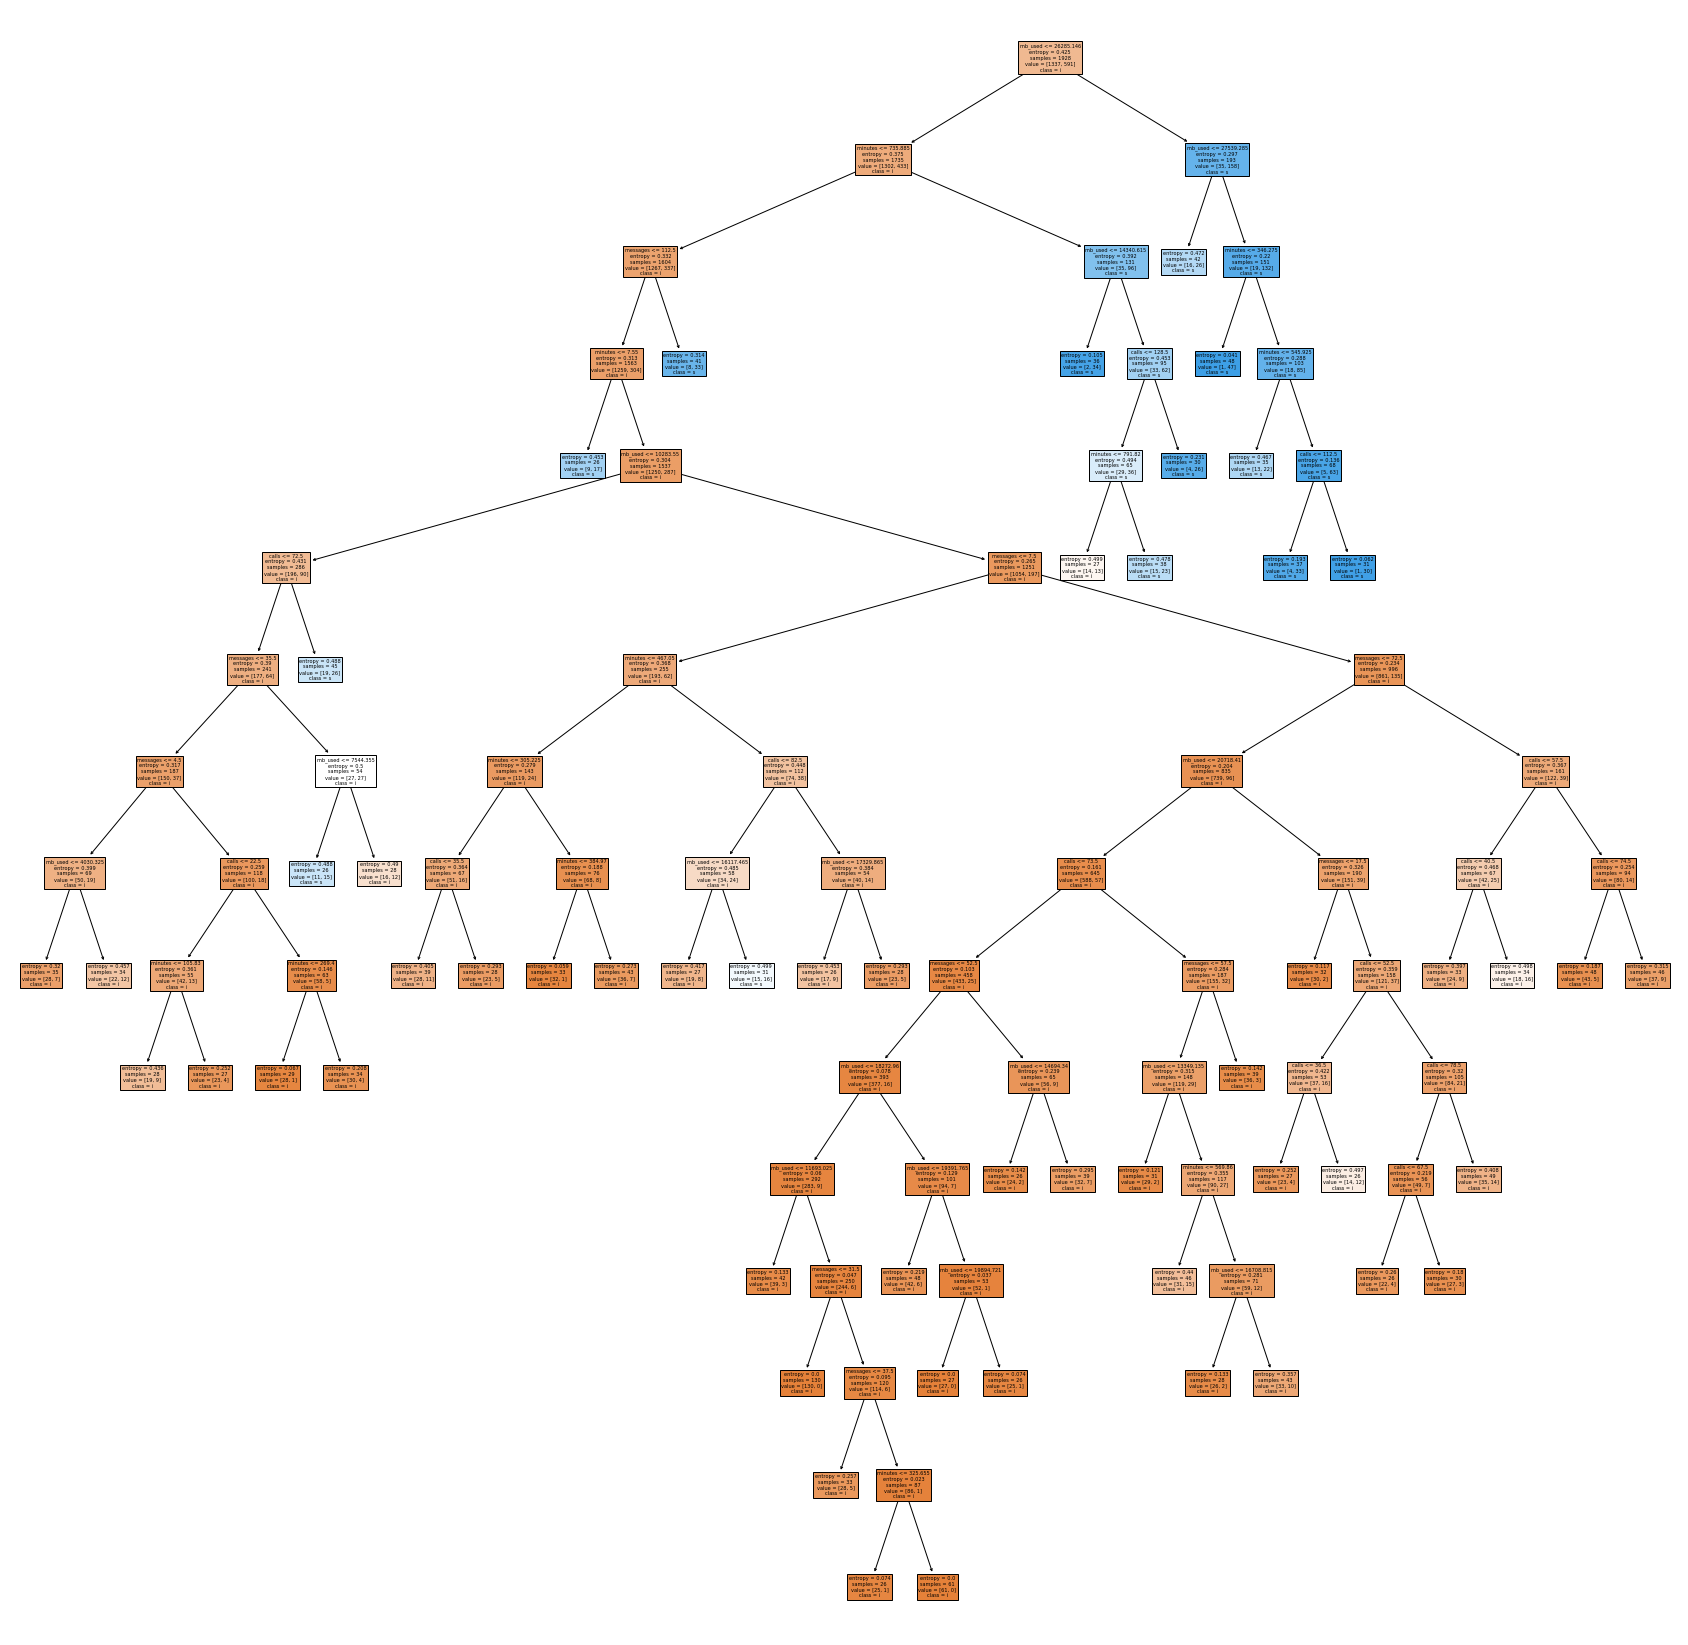

In [37]:
plt.figure(figsize=(30,30))
tree.plot_tree(dtc, feature_names=features_df_train.columns,
               class_names=target_df_train.name, filled=True, fontsize=5)
plt.show()

В итоге получаем, что самое большое значение `accuracy`, которое смогли подобрать руками  - 0.8009 с критерием Gini,  min_samples_leaf =26, max_features = 3, max_depth = 7

## Случайный лес

In [40]:
model = RandomForestClassifier(random_state=1)

Обучим случайный лес по дефолту

In [41]:
model.fit(features_df_train, target_df_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [42]:
train_predictions = model.predict(features_df_train)

In [43]:
train_accuracy = accuracy_score(target_df_train, train_predictions)
train_accuracy

0.9745850622406639

Точность предсказания на тренировачной выборке 0,9745. Результат неплохой, что же проверим как работате модель на валидационной выборке

In [44]:
valid_predictions = model.predict(features_df_valid)

In [45]:
valid_accuracy = accuracy_score(target_df_valid, valid_predictions)
valid_accuracy

0.7838258164852255

0.7838 - Весьма не плохо, доля правильных ответов намного лучше чем на дереве решений(0,7013 acurracy) так же с дефолтными параметрами.

Поиграемся с кол-вом деревьев в случайном лесе, попробуем улучшить долю правильных ответов

In [46]:
best_n_estimators = None
best_result = 0
for est in range(1, 10):
    model = RandomForestClassifier(random_state=1, n_estimators = est)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_n_estimators = est
print('Наилучший Accuracy:', best_result, 'c кол-вом деревьев', best_n_estimators)

Наилучший Accuracy: 0.7900466562986003 c кол-вом деревьев 8


In [47]:
best_n_estimators = None
best_result = 0
for est in range(1, 100):
    model = RandomForestClassifier(random_state=1, n_estimators = est)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_n_estimators = est
print('Наилучший Accuracy:', best_result, 'c кол-вом деревьев', best_n_estimators)

Наилучший Accuracy: 0.7962674961119751 c кол-вом деревьев 22


In [48]:
best_n_estimators = None
best_result = 0
for est in range(1, 200):
    model = RandomForestClassifier(random_state=1, n_estimators = est)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_n_estimators = est
print('Наилучший Accuracy:', best_result, 'c кол-вом деревьев', best_n_estimators)

Наилучший Accuracy: 0.7962674961119751 c кол-вом деревьев 22


Итак с неграмозкими вычислениями получилось, что лес состоящий из 22 деревьев приносит наилучший результат с долей правильных ответов 0.7962

Теперь попробуем улучшить модель, если покрутим максимальное число признаков, по которым ищется наилучшее разбиение max_features

In [49]:
for features in range(1, 5):
    model = RandomForestClassifier(random_state=1, max_features=features)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    print('max_features =', features, ':', result)

max_features = 1 : 0.7931570762052877
max_features = 2 : 0.7838258164852255
max_features = 3 : 0.7744945567651633
max_features = 4 : 0.7853810264385692


Получилось, что модель, где классивикация оценивается лишь по 1 признаку, дает наилучший результат со значением 0,7931 что не серьезно, будем крутить другие гиперпараметры

Попробуем "поиграться" с высотой леса

In [50]:
best_max_depth = None
best_result = 0
for depth in range(1, 10):
    model = RandomForestClassifier(random_state=1, max_depth=depth)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_max_depth = depth
print('Наилучший Accuracy:', best_result, 'c высостой леса', best_max_depth)

Наилучший Accuracy: 0.8040435458786936 c высостой леса 6


In [51]:
best_max_depth = None
best_result = 0
for depth in range(1, 100):
    model = RandomForestClassifier(random_state=1, max_depth=depth)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_max_depth = depth
print('Наилучший Accuracy:', best_result, 'c высостой леса', best_max_depth)

Наилучший Accuracy: 0.8040435458786936 c высостой леса 6


In [52]:
best_max_depth = None
best_result = 0
for depth in range(1, 200):
    model = RandomForestClassifier(random_state=1, max_depth=depth)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_max_depth = depth
print('Наилучший Accuracy:', best_result, 'c высостой леса', best_max_depth)

Наилучший Accuracy: 0.8040435458786936 c высостой леса 6


Итак оптимальная высота леса равна 6 с долей правльных ответов 0,8040

Посмотрим что даст (min_samples_split) минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться

In [53]:
best_min_samples_split = None
best_result = 0
for split in range(2, 10):
    model = RandomForestClassifier(random_state=1, min_samples_split=split)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_min_samples_split = split
print('Наилучший Accuracy:', best_result, 'с минимальным число объектов для расщепления', best_min_samples_split)

Наилучший Accuracy: 0.8009331259720062 с минимальным число объектов для расщепления 7


In [54]:
best_min_samples_split = None
best_result = 0
for split in range(2, 100):
    model = RandomForestClassifier(random_state=1, min_samples_split=split)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_min_samples_split = split
print('Наилучший Accuracy:', best_result, 'с минимальным число объектов для расщепления', best_min_samples_split)

Наилучший Accuracy: 0.8133748055987559 с минимальным число объектов для расщепления 26


In [55]:
best_min_samples_split = None
best_result = 0
for split in range(2, 200):
    model = RandomForestClassifier(random_state=1, min_samples_split=split)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_min_samples_split = split
print('Наилучший Accuracy:', best_result, 'с минимальным число объектов для расщепления', best_min_samples_split)

Наилучший Accuracy: 0.8133748055987559 с минимальным число объектов для расщепления 26


Итак минимум 26 объектов в узле и можно расщеплять. Данный гиперпараметр дает пока наилучший accuracy 0.8133 

Теперь попробуем изменить минимальное число объектов которое будет содержаться в листе деревьев - параметр min_samples_leaf. 

In [56]:
best_min_samples_leaf = None
best_result = 0
for leaf in range(1, 10):
    model = RandomForestClassifier(random_state=1, min_samples_leaf=leaf)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_min_samples_leaf = leaf
print('Наилучший Accuracy:', best_result, 'с минимальным числом объектов в листе', best_min_samples_leaf)

Наилучший Accuracy: 0.807153965785381 с минимальным числом объектов в листе 9


In [57]:
best_min_samples_leaf = None
best_result = 0
for leaf in range(1, 100):
    model = RandomForestClassifier(random_state=1, min_samples_leaf=leaf)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_min_samples_leaf = leaf
print('Наилучший Accuracy:', best_result, 'с минимальным числом объектов в листе', best_min_samples_leaf)

Наилучший Accuracy: 0.807153965785381 с минимальным числом объектов в листе 9


In [58]:
best_min_samples_leaf = None
best_result = 0
for leaf in range(1, 200):
    model = RandomForestClassifier(random_state=1, min_samples_leaf=leaf)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_min_samples_leaf = leaf
print('Наилучший Accuracy:', best_result, 'с минимальным числом объектов в листе', best_min_samples_leaf)

Наилучший Accuracy: 0.807153965785381 с минимальным числом объектов в листе 9


Оптимальное минимальное число объектов в листе 9 с наибольшей долей верных предсказаний 0.8071 по нашим расчетам

Объединим несколько наилучших гиперпараметров, посмотрим что выйдет, насколько улучшиться прогноз.

In [59]:
model = RandomForestClassifier(random_state=1, n_estimators=22, max_depth=6, min_samples_split=26, min_samples_leaf=9)
model.fit(features_df_train, target_df_train)
valid_predictions = model.predict(features_df_valid)
result = accuracy_score(target_df_valid, valid_predictions)
result

0.8009331259720062

Попробуем тоже самое с энтропией (на основе прироста информации) 

In [60]:
model = RandomForestClassifier(random_state=1,criterion = 'entropy',
                               n_estimators=22, max_depth=6, min_samples_split=26, min_samples_leaf=9)
model.fit(features_df_train, target_df_train)
valid_predictions = model.predict(features_df_valid)
result = accuracy_score(target_df_valid, valid_predictions)
result

0.7993779160186625

Для данных гиперпараметров попробуем всетаки все таки определить оптимальное число деревьев

In [61]:
best_n_estimators = None
best_result = 0
for est in range(1, 10):
    model = RandomForestClassifier(random_state=1, n_estimators = est, max_depth=6, min_samples_split=26, min_samples_leaf=9)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_n_estimators = est
print('Наилучший Accuracy:', best_result, 'c кол-вом деревьев', best_n_estimators)

Наилучший Accuracy: 0.8040435458786936 c кол-вом деревьев 6


In [62]:
best_n_estimators = None
best_result = 0
for est in range(1, 100):
    model = RandomForestClassifier(random_state=1, n_estimators = est, max_depth=6, min_samples_split=26, min_samples_leaf=9)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_n_estimators = est
print('Наилучший Accuracy:', best_result, 'c кол-вом деревьев', best_n_estimators)

Наилучший Accuracy: 0.807153965785381 c кол-вом деревьев 54


In [63]:
best_n_estimators = None
best_result = 0
for est in range(1, 200):
    model = RandomForestClassifier(random_state=1, n_estimators = est, max_depth=6, min_samples_split=26, min_samples_leaf=9)
    model.fit(features_df_train, target_df_train)
    valid_predictions = model.predict(features_df_valid)
    result = accuracy_score(target_df_valid, valid_predictions)
    if result > best_result:
        best_result = result
        best_n_estimators = est
print('Наилучший Accuracy:', best_result, 'c кол-вом деревьев', best_n_estimators)

Наилучший Accuracy: 0.807153965785381 c кол-вом деревьев 54


В итоге наибольшее значение accuracy 0.8133 дало лишь min_samples_split = 26

## Логистическая регрессия

Построим логистическую регрессию по дефолту и сразу проверим Accuracy

In [65]:
model = LogisticRegression(random_state=1)
model.fit(features_df_train, target_df_train)
result = model.score(features_df_valid, target_df_valid)
result

0.7511664074650077

Accuracy 0.7511 неплохо, но попробуем получить результат лучше поколдовав с гиперпараметрами

In [66]:
model = LogisticRegression(random_state=1, penalty = 'l1')
model.fit(features_df_train, target_df_train)
result = model.score(features_df_valid, target_df_valid)
result

0.7511664074650077

In [67]:
model = LogisticRegression(random_state=1, warm_start = 1)
model.fit(features_df_train, target_df_train)
result = model.score(features_df_valid, target_df_valid)
result

0.7511664074650077

In [68]:
model = LogisticRegression(random_state=1, max_iter = 200)
model.fit(features_df_train, target_df_train)
result = model.score(features_df_valid, target_df_valid)
result

0.7511664074650077

Не смотря на то, что меняю гиперпараметры accuracy остается неизменной, однако скорость предсказания радует.

## Вывод:

- Дерево решений показало наилучший результат 0.8009 доли правильных предсказаний на валидационной выборке со следующими подобранными рукми гиперпараметрами: критерием классификации Gini impurity,  минимальным числом объектов в лисет (min_samples_leaf) равным 26, максимальным числом фичей по котрым производиться разбиение (max_features) равным 3, высотой дерева (max_depth) равным 7
- Случайны лес показа наилучший результат 0.8133 лишь отрегулировав минимальное число объектов для расщепление равным (min_samples_split) 26
- Логистическая регрессия дала результат 0.7511. Пытался менять гиперпараметры, однако в ручном подборе значение не изменилось.

В целом на валидационной выборке мы добились значения 0.75. Следует сказать что руками сложно подобрать оптимальное значение гиперпараметров, особенно со случайным лесом, так нужны значительные вычислительные мощности

<a id = 'section4'></a>
# Провека модели на тестовой выборке

Еще раз обучим модели с наилучшими подобранными гиперпараметрами, для того что бы в дальнейшем использовать их для тестовой выборки

## Дерево решений

In [69]:
dtc = DecisionTreeClassifier(random_state=1, min_samples_leaf =26, max_features = 3, max_depth=7)
dtc.fit(features_df_train, target_df_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=26, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [70]:
test_predictions_dtc = dtc.predict(features_df_test)
result = accuracy_score(target_df_test, test_predictions_dtc)
print('Accuracy для дерева решений с наилучшими подобранными гиперпараметрами:', result)

Accuracy для дерева решений с наилучшими подобранными гиперпараметрами: 0.8055987558320373


## Случайный лес

In [71]:
rfc = RandomForestClassifier(random_state=1, min_samples_split=26)
rfc.fit(features_df_train, target_df_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=26,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [72]:
test_predictions_rfc = rfc.predict(features_df_test)
result = accuracy_score(target_df_test, test_predictions_rfc)
print('Accuracy для случайного леса с наилучшими подобранными гиперпараметрами:', result)

Accuracy для случайного леса с наилучшими подобранными гиперпараметрами: 0.8133748055987559


## Логистическая регрессия

In [73]:
lr = LogisticRegression(random_state=1)
lr.fit(features_df_train, target_df_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
result = lr.score(features_df_test, target_df_test)
print('Accuracy для логистической регрессии с наилучшими подобранными гиперпараметрами:', result)

Accuracy для логистической регрессии с наилучшими подобранными гиперпараметрами: 0.7511664074650077


## Вывод:

На тестовой выборке попрежнему наилучшей моделью осталась - случайны лес с долей верных ответов 0.8133. Следует отметить, что для результат дерева решений на тестовой выборке улучшился по сравнению с валидационной с 0.8009 до 0.8056. Поставленной задачи accuracy равной не менее 0.75 мы добились во всех моделях.

<a id = 'section5'></a>
# Проверка модели на адекватность

Возьмем базовую модель и попробуем сравнить ее accuracy с нашей лушей моделью

In [76]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf.fit(features_df_train, target_df_train)
dummy_clf.score(features_df_test, target_df_test)

0.6936236391912908

Очевидно, что наша модель с accuracy = 0.8133 работает намного лучше

## Общий вывод

- Наилучшей моделью в нашей задаче классификации с точки зрения accuracy является случайный лес со значением 0.8133
- По скорости обработки данных можно считать лучшей Логистическую регрессия, но значения accuracy на порядок ниже
- Дерево решений является стабильным средничком, показывает неплохие значения accuracy и не так долго обрабатывает данные.

В целом на небольших данных не так сложно подобрать неплохие гиперпараметры для модели, но если данных достаточно много, то лучше подьзовать другим инструментарием, в том числе крос валидацией, что сократит подбор и не сильно загрузит наши мощности.